In [0]:
from __future__ import division 
import time 
import json
import pandas as pd
import numpy as np 
import string, re
from scipy.sparse import csr_matrix
import sys 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier 
import math 

In [0]:
import json

f=open('/content/drive/My Drive/mlhw3p4/labeled_small.json','r')

data=json.load(f)

Part 1

In [0]:
brewers = []
beers = []

for i in range(100000):
    beers.append(data[i]['beer_name'])
    brewers.append(data[i]['brewer'])
                   
beers_u = list(set(beers))
brewers_u = list(set(brewers))

beer_ratings = {}
brew_ratings = {}
for beer in beers_u:
    beer_ratings[beer] = []
for brew in brewers_u: 
    brew_ratings[brew] = []
    
for i in range(100000):
    beer_ratings[data[i]['beer_name']].append(data[i]['overall'])
    brew_ratings[data[i]['brewer']].append(data[i]['overall'])

In [267]:
print('Beers:\n')
i = 0
for beer in beers_u:
    if i<10: print(f"{beer}:")
    mean = np.mean(beer_ratings[beer])
    median = np.median(beer_ratings[beer])
    sd = np.std(beer_ratings[beer])
    if i<10: print(f"Mean: {mean}, median: {median}, standard deviation: {sd}\n")
    i = i+1

Beers:

Custom Brewcrafters Duffs Beer Ale:
Mean: 11.5, median: 11.5, standard deviation: 1.5

Brainerd Lakes One-Eyed Pike:
Mean: 11.6, median: 12.0, standard deviation: 1.8547236990991407

Why Not On the Ball:
Mean: 13.5, median: 13.5, standard deviation: 0.5

Big Dogs Chipotle Lime Ale:
Mean: 13.0, median: 13.0, standard deviation: 0.0

JWs Dry Fen Cider:
Mean: 10.0, median: 10.0, standard deviation: 0.0

Big Dogs Balls of Holly Christmas Ale:
Mean: 17.0, median: 17.0, standard deviation: 0.0

Kapsreiter Aloe Bier:
Mean: 12.0, median: 12.0, standard deviation: 0.0

Ottweiler German Beer:
Mean: 3.0, median: 3.0, standard deviation: 0.0

Specht Bockbier:
Mean: 12.833333333333334, median: 12.5, standard deviation: 2.088327347690278

Karlsberg Mixery Bier + Cherry:
Mean: 6.8125, median: 7.0, standard deviation: 1.7399263633843818



In [268]:
print('Brewers:\n')
i=0
for brew in brewers_u:
    if i<10: print(f"{brew}:")
    mean = np.mean(brew_ratings[brew])
    median = np.median(brew_ratings[brew])
    sd = np.std(brew_ratings[brew])
    if i<10: print(f"Mean: {mean}, median: {median}, standard deviation: {sd}\n")
    i=i+1

Brewers:

0:
Mean: 12.836223506743737, median: 13.0, standard deviation: 2.5432971325766625

2055:
Mean: 13.21161825726141, median: 14.0, standard deviation: 2.613567750297056

10:
Mean: 14.141904761904762, median: 14.0, standard deviation: 2.2235084939517855

4109:
Mean: 14.0, median: 14.0, standard deviation: 0.0

4115:
Mean: 14.626966292134831, median: 15.0, standard deviation: 2.565841476399087

2082:
Mean: 13.0, median: 13.0, standard deviation: 2.147937700129211

2092:
Mean: 11.0, median: 11.0, standard deviation: 0.0

4145:
Mean: 13.0, median: 13.0, standard deviation: 0.816496580927726

4150:
Mean: 14.8892455858748, median: 15.0, standard deviation: 2.420272176509786

58:
Mean: 12.76923076923077, median: 14.0, standard deviation: 2.832608098387995



In [0]:
# People do seem to have similar tastes, as the standard deviation for most brewers is lower than the overall SD of roughly
# 3, and the SD for most of the beers is even lower.

Part 2a

In [0]:
f = open('/content/drive/My Drive/mlhw3p4/vocab_30.json', 'r')
vocab = json.load(f)
inv_vocab = {v: k for k, v in vocab.items()}

def clean_and_split(s):
    # encode to UTF-8, convert to lowercase and translate all hyphens and
    # punctuation to whitespace
    s = s.lower().replace('-',' ')
    # replace \r\n
    s = re.sub('(\r\n)+',' ',s)
    # replace whitespace substrings with one whitespace and remove
    # leading/trailing whitespaces
    s = re.sub(' +',' ',s.strip())
    return s.split(' ')  

In [0]:
indptr = [0]
indices = []
csr_data = []
for i in range(100000):
  words = clean_and_split(data[i]['review'])
  for word in words:
    if word in vocab.keys():
      index = vocab[word]
      indices.append(index)
      csr_data.append(1)
  indptr.append(len(indices))

In [0]:
csr_features = csr_matrix((csr_data, indices, indptr), dtype=int)

In [0]:
csr_training = csr_features[0:70000]
csr_validation = csr_features[70000:85000]
csr_testing = csr_features[85000:100000]

In [0]:
sentiments = np.ones((100000))
for i in range(100000):
  if data[i]['overall'] < 14:
    sentiments[i] = -1

y_training = sentiments[0:70000]
y_validation = sentiments[70000:85000]
y_testing = sentiments[85000:100000] 

Part 2b

In [0]:
log_loss = LogisticRegression(penalty='l2', C=0.1, max_iter=1000).fit(csr_training,y_training)

In [63]:
score_log = log_loss.score(csr_validation,y_validation)
print(score_log)

0.7008


In [0]:
# The model only takes a few seconds to train. The best value C seems to be 0.1.

In [0]:
hinge_loss = LinearSVC(penalty='l2',loss='hinge',C=0.1,max_iter=1000).fit(csr_training,y_training)

In [79]:
score_hinge = hinge_loss.score(csr_validation,y_validation)
print(score_hinge)

0.6944


In [0]:
# The two losses do not produce significantly different results. 

Part 2c

In [0]:
from random import shuffle

In [0]:
def acc_validation(weights):
  n_correct = 0
  for i in range(15000):
    xi = csr_validation[i]
    if xi.dot(weights).toarray() > 0 and y_validation[i] == 1:
      n_correct = n_correct + 1
    if xi.dot(weights).toarray() < 0 and y_validation[i] == -1:
      n_correct = n_correct + 1  
  return n_correct/15000

def acc_training(weights):
  n_correct = 0
  for i in range(70000):
    xi = csr_training[i]
    if xi.dot(weights).toarray() > 0 and y_training[i] == 1:
      n_correct = n_correct + 1
    if xi.dot(weights).toarray() < 0 and y_training[i] == -1:
      n_correct = n_correct + 1
  return n_correct/70000

def acc_testing(weights): 
  n_correct = 0
  for i in range(15000):
    xi = csr_testing[i]
    if xi.dot(weights).toarray() > 0 and y_testing[i] == 1:
      n_correct = n_correct + 1
    if xi.dot(weights).toarray() < 0 and y_testing[i] == -1:
      n_correct = n_correct + 1
  return n_correct/15000

In [0]:
theta = csr_matrix((len(vocab)-1,1))
delta = 0.0005
C = 100

In [197]:
for epoch in range(5):

  ll = 0

  for batch in range(700):

    indices = np.arange(csr_training.shape[0])
    shuffle(indices)
    shuffled_csr_training = csr_training[list(indices)]
    shuffled_y_training = y_training[list(indices)]

    G=csr_matrix((1,len(vocab)-1))
    # if batch%10 == 0: print(batch)
    x = shuffled_csr_training[100*batch:100*(batch+1)]
    pred = x.dot(theta)

    for i in range(100):

      yi = shuffled_y_training[100*batch + i]
      eta = pred[i].toarray()
      xi = x[i]

      exponent = eta*yi*2
      if exponent > 700: a = 0
      else: a = 1/(1+math.exp(exponent))
      grad = -xi.dot(yi).dot(a) + theta.dot(2/C).T
      lli = np.log(1+math.exp(-exponent))

      G = G + grad
      ll = ll + lli

    theta = np.subtract(theta,G.dot(delta).T)
  
  acc_t = acc_training(theta)
  acc_v = acc_validation(theta)

  print(f"epoch: {epoch}, training set accuracy: {acc_t},",
  f"validation set accuracy: {acc_v}, negative log likelihood: {ll}")

epoch: 0, training set accuracy: 0.7065142857142858, validation set accuracy: 0.7427333333333334, negative log likelihood: 43064.812878995035
epoch: 1, training set accuracy: 0.7127, validation set accuracy: 0.7484666666666666, negative log likelihood: 40984.54653561792
epoch: 2, training set accuracy: 0.7151714285714286, validation set accuracy: 0.7504666666666666, negative log likelihood: 40662.13702200697
epoch: 3, training set accuracy: 0.7161571428571428, validation set accuracy: 0.7508, negative log likelihood: 40564.846253356496
epoch: 4, training set accuracy: 0.7164857142857143, validation set accuracy: 0.7508, negative log likelihood: 40530.05929546808


In [0]:
train_err_rates = [1-0.7065, 1-0.7127, 1-0.7152, 1-0.7162, 1-0.7165]
validation_err_rates = [1-0.7427, 1-0.7485, 1-0.7505, 1-0.7508, 1-0.7508]
lls = [43065, 40985, 40662, 40565, 40530]
x = [0,1,2,3,4]

Blue: Training Set Error Rates, Orange: Validation Set Error Rates


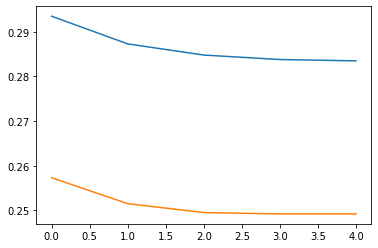

In [208]:
plt.plot(x, train_err_rates, validation_err_rates)
print("Blue: Training Set Error Rates, Orange: Validation Set Error Rates")

Negative Log Likelihoods by Iteration


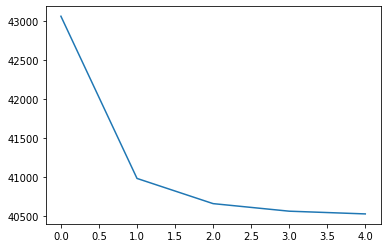

In [210]:
plt.plot(x, lls)
print("Negative Log Likelihoods by Iteration")

In [269]:
print(f"Test set error: {acc_testing(theta)}")

Test set error: 0.7337333333333333


In [0]:
# The time to train is much higher for my model, but the error rate is slightly lower.

Part 3

In [0]:
new_feat = np.zeros((100000,5))
for i in range(100000):
  new_feat[i][0] = data[i]['appearance']
  new_feat[i][1] = data[i]['aroma']
  new_feat[i][2] = data[i]['palate']
  new_feat[i][3] = data[i]['style']
  new_feat[i][4] = data[i]['taste']

new_training = new_feat[:70000,:]
new_validation = new_feat[70000:85000,:]
new_testing = new_feat[85000:100000,:]  

In [0]:
def new_acc_validation(weights):
  n_correct = 0
  for i in range(15000):
    xi = new_validation[i,:]
    if xi.dot(weights) > 0 and y_validation[i] == 1:
      n_correct = n_correct + 1
    if xi.dot(weights) < 0 and y_validation[i] == -1:
      n_correct = n_correct + 1  
  return n_correct

def new_acc_training(weights):
  n_correct = 0
  for i in range(70000):
    xi = new_training[i,:]
    if xi.dot(weights) > 0 and y_training[i] == 1:
      n_correct = n_correct + 1
    if xi.dot(weights) < 0 and y_training[i] == -1:
      n_correct = n_correct + 1
  return n_correct/70000

def new_acc_testing(weights): 
  n_correct = 0
  for i in range(15000):
    xi = new_testing[i,:]
    if xi.dot(weights) > 0 and y_testing[i] == 1:
      n_correct = n_correct + 1
    if xi.dot(weights) < 0 and y_testing[i] == -1:
      n_correct = n_correct + 1
  return n_correct/15000

In [0]:
theta2 = np.zeros((5,1))
delta2 = 0.001
C2 = 1

In [264]:
for epoch in range(5):

  ll = 0

  for batch in range(700):

    indices = np.arange(new_training.shape[0])
    shuffle(indices)
    shuffled_new_training = new_training[list(indices)]
    shuffled_ynew_training = y_training[list(indices)]

    G=csr_matrix((1,5))
    # if batch%10 == 0: print(batch)
    x = shuffled_new_training[100*batch:100*(batch+1),:]
    pred = x.dot(theta2)

    for i in range(100):

      yi = shuffled_ynew_training[100*batch + i]
      eta = pred[i]
      xi = x[i]

      exponent = eta*yi*2
      if exponent > 700: a = 0
      else: a = 1/(1+math.exp(exponent))
      grad = -xi.dot(yi).dot(a) + theta2.dot(2/C2).T
      if -exponent > 700: lli = -exponent
      else: lli = np.log(1+math.exp(-exponent))

      G = G + grad
      ll = ll + lli

    theta2 = np.subtract(theta2,G.dot(delta2).T)
  
  acc_t = new_acc_training(theta2)
  acc_v = new_acc_validation(theta2)

  print(f"epoch: {epoch}, training set accuracy: {acc_t},",
  f"validation set accuracy: {acc_v}, negative log likelihood: {ll}")

epoch: 0, training set accuracy: 0.5616714285714286, validation set accuracy: 0.7819333333333334, negative log likelihood: 2543778.730514741
epoch: 1, training set accuracy: 0.5616714285714286, validation set accuracy: 0.7819333333333334, negative log likelihood: 2510116.34682949
epoch: 2, training set accuracy: 0.43832857142857146, validation set accuracy: 0.21806666666666666, negative log likelihood: 2503363.8774240366
epoch: 3, training set accuracy: 0.43832857142857146, validation set accuracy: 0.21806666666666666, negative log likelihood: 2514189.312282659
epoch: 4, training set accuracy: 0.5616714285714286, validation set accuracy: 0.7819333333333334, negative log likelihood: 2531750.0349724903


In [265]:
print(f"Error rate on testing set: {1-new_acc_testing(theta2)}")

Error rate on testing set: 0.3214666666666667


In [0]:
# The first model predicts better. I think this is because, with over 40000 parameters, the first model
# can adjust predictions much more finely, whereas the new model seems to either classify
# all reviews as negative and all as positive. 